<a href="https://colab.research.google.com/github/giuliovv/airbullet/blob/master/duckietown_stablebaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train duckietown with stable baseline

Environment setup 

In [37]:
import os 
if not os.path.isdir('gym-duckietown') or os.path.isdir('../gym-duckietown'):
  branch = "master" #@param ['master', 'daffy']
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if os.getcwd() != "/gym-duckietown":
  os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

Cloning into 'gym-duckietown'...
remote: Enumerating objects: 5528, done.
remote: Total 5528 (delta 0), reused 0 (delta 0), pack-reused 5528
Receiving objects: 100% (5528/5528), 79.01 MiB | 41.70 MiB/s, done.
Resolving deltas: 100% (3220/3220), done.
Obtaining file:///content/gym-duckietown/gym-duckietown/gym-duckietown/gym-duckietown
  Found existing installation: gym-duckietown 2019.0.0
    Can't uninstall 'gym-duckietown'. No files were found to uninstall.
  Running setup.py develop for gym-duckietown
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


Install stable baseline

In [38]:
# Stable baseline requires tensorflow 1.x
%tensorflow_version 1.x

In [39]:
!apt update && apt install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip3 install stable-baselines[mpi]
#This version with mpi is apparently broken, see:
#https://github.com/hill-a/stable-baselines/issues/464
!pip3 install stable-baselines --upgrade

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (155 kB/s

In [40]:
map_name = "Duckietown-small_loop-v0" #@param ['Duckietown-straight_road-v0','Duckietown-4way-v0','Duckietown-udem1-v0','Duckietown-small_loop-v0','Duckietown-small_loop_cw-v0','Duckietown-zigzag_dists-v0','Duckietown-loop_obstacles-v0','Duckietown-loop_pedestrians-v0']

Wrapper to highlight lines

In [41]:
import cv2
import gym
from gym.spaces import Box

cutted_img_height = 350
resize_ratio = 0.5

img_height = 480
top_crop = img_height - cutted_img_height

img_final_height = int(cutted_img_height * resize_ratio)
img_final_width = int(640 * resize_ratio)

def cropimg(img):
    """
    Crop top of image top_crop px, they are noise most of the time

    :param img: (RGB image as np array) Image to be cropped
    """
    return img[top_crop:,:]

def houghtransform(img):
    """
    Apply Hough Line transform, for theory see:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

    :param img: (RGB image as np array)
    """
    frame_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY, 3)
    edges = cv2.Canny(frame_BGR,50,150,apertureSize = 3)
    #minLineLength = 100
    #maxLineGap = 10
    #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    #for x1,y1,x2,y2 in lines[0]:
    #    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    imgRGB = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
    return imgRGB

def resizeimg(img, ratio):
    """
    Resize image
    :param img: (np array)
    :param ratio: (float) 0<ratio<1
    """
    return cv2.resize(img, (0,0), fx=ratio, fy=ratio) 
  
def takeyellow(img):
    """
    Extract yellow lines, for color ranges see:
    https://stackoverflow.com/questions/48109650/how-to-detect-two-different-colors-using-cv2-inrange-in-python-opencv

    :param img: (RGB image as np array)
    """
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    frame_threshold = cv2.inRange(frame_HSV, (20,100,100), (50, 255, 255))
    imgRGB = cv2.cvtColor(frame_threshold, cv2.COLOR_GRAY2RGB)
    return imgRGB

def takewhiteyellow(img):
    """
    Extract white and yellow lines

    :param img: (RGB image as np array)
    """
    #white
    sensitivity = 100
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskwhite = cv2.inRange(frame_HSV, lower_white, upper_white)
    img[maskwhite > 0] = (255, 0, 0)
    img[maskwhite == 0] = (0,0,0)
    #yellow
    maskyellow = cv2.inRange(frame_HSV, (15,70,70), (50, 255, 255))
    img[maskyellow > 0] = (0, 255, 0)
    return img

def white_balance(img):
    """
    Grayworld assumption:
    https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption/46391574

    :param img: (RGB image as np array)
    """
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

class ObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ObsWrapper, self).__init__(env)
        self.observation_space = Box(0, 255, (img_final_height, img_final_width, 3), dtype=self.observation_space.dtype)
        self.accept_start_angle_deg = 4
        self.env = env

    def observation(self, obs):
        cropped = cropimg(obs)
        resized = resizeimg(cropped, resize_ratio)
        balanced = white_balance(resized)
        img = takewhiteyellow(balanced)
        return img

In [ ]:
class NormalizeWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ObsWrapper, self).__init__(env)
        self.env = env

    def observation(self, obs):
        obs = obs/255
        return img

Wrapper result example:

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


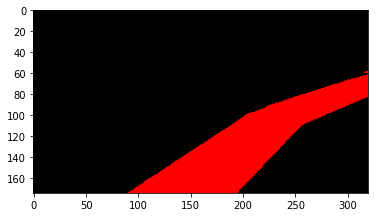

In [42]:
import gym_duckietown

display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name, accept_start_angle_deg=4)
env = ObsWrapper(env)
plt.imshow(env.reset())

In [ ]:
env = NormalizeWrapper(env)

In [43]:
env.observation_space

Box(0, 255, (175, 320, 3), uint8)

In [44]:
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines import A2C
from stable_baselines.common.policies import CnnLstmPolicy

model = A2C(CnnLstmPolicy, env, verbose=1)
model.learn(total_timesteps=100000)
model.save("a2c"+map_name)

ipythondisplay.clear_output(wait=True)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | -0.00591 |
| fps                | 9        |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00208 |
| fps                | 54       |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 24       |
---------------------------------
---------------------------------
| explained_variance | 0.0091   |
| fps                | 57       |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 35.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0185  |
| fps                | 58       |
| nupdates           | 300      |
| policy_entr

In [45]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [46]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [47]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: NormalizeWrapper(ObsWrapper(gym.make(map_name, accept_start_angle_deg=4)))])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, reward, done, _ = eval_env.step(action)
    if done and reward < 0:
      print("*** CRASHED ***")
    elif done:
      print("SAFE")
    

  # Close the video recorder
  eval_env.close()

In [48]:
record_video(model, video_length=500, prefix=map_name)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
*** CRASHED ***
Saving video to  /content/gym-duckietown/gym-duckietown/gym-duckietown/g

In [49]:
show_videos('videos', prefix=map_name)

In [50]:
#from stable_baselines import A2C
#model = A2C.load("a2c"+map_name)